In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow

2025-03-09 16:58:42.828337: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 16:58:42.921621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741514322.958285    7301 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741514322.970082    7301 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 16:58:43.058489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, GlobalAvgPool2D, DepthwiseConv2D, ReLU
from tensorflow.keras.models import Model
import glob

In [5]:
tensorflow.__version__

'2.18.0'

# Prepare Data

In [7]:
import cv2 as cv

In [8]:
import os
# lấy danh sách đường dẫn
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

In [9]:
def getData( link ):

  X = []  #Image
  y = []  #Label

  list_name = get_immediate_subdirectories(link)

  for label in list_name:
    # lấy link ảnh
    for file_name in glob.glob(link + "/" + label+"/*"):
      img = cv.imread(file_name)
      # đọc ảnh
      img_cvt = cv.cvtColor(img,cv.COLOR_BGR2RGB)
      # chuyển về dạng RGB
      img_cvt = cv.resize(img_cvt,(224,224))
      # đưa về size 224 X 224 x 3
      X.append(img_cvt)
      y.append(label)

  return X,y

In [10]:
#lấy từng bộ data
X_train, y_train = getData("Vegetable Images/train")
X_test, y_test = getData("Vegetable Images/test")
X_val, y_val = getData("Vegetable Images/validation")

In [11]:
# Chuyển về dạng array
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [12]:
#Kiểm tra shape của các tập
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((15000, 224, 224, 3),
 (15000,),
 (3000, 224, 224, 3),
 (3000,),
 (3000, 224, 224, 3),
 (3000,))

In [13]:
from tensorflow.keras.utils import to_categorical

# Tạo một danh sách các nhãn dạng số nguyên
labels = np.arange(15)
# Lấy danh sách label
names = np.unique(y_train)

name_label={}
label_name = {}
for i in range(15):
  name_label[names[i]] = labels[i]
  label_name[labels[i]] = names[i]
y_train_encode = []
y_test_encode = []
y_val_encode = []
for label in y_train:
  y_train_encode.append( name_label[label] )
for label in y_val:
  y_val_encode.append( name_label[label] )
for label in y_test:
  y_test_encode.append( name_label[label] )

y_train_encode = np.array(y_train_encode)
y_test_encode = np.array(y_test_encode)
y_val_encode = np.array(y_val_encode)

#đưa về dạng vecto 1 chieu
y_train_encode = np.reshape(y_train_encode,(y_train_encode.shape[0],1))
y_val_encode = np.reshape(y_val_encode,(y_val_encode.shape[0],1))
y_test_encode = np.reshape(y_test_encode,(y_test_encode.shape[0],1))

In [14]:
label_name

{0: 'Bean',
 1: 'Bitter_Gourd',
 2: 'Bottle_Gourd',
 3: 'Brinjal',
 4: 'Broccoli',
 5: 'Cabbage',
 6: 'Capsicum',
 7: 'Carrot',
 8: 'Cauliflower',
 9: 'Cucumber',
 10: 'Papaya',
 11: 'Potato',
 12: 'Pumpkin',
 13: 'Radish',
 14: 'Tomato'}

In [15]:
from tensorflow.keras import layers
# input_shape: kich thuoc anh dau vao, n_classes: so lop phan loai
def mobilenet(input_shape, n_classes):
    # khoi mobilenet, gom depthwise convolution de giam so luong trong so va  pointwise convolution de lam tang chieu sau
    # giam so lượng trọng số giúp giảm bộ nhớ cho mô hình
    # tăng chiều sấu cho feature map để trích xuất các đặc trưng phức từ từ ảnh giúp tăng độ chính xác và hiệu suất cảu mô hình
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    #  Với mỗi kênh đầu vào, lớp này sẽ áp dụng một kernel (bộ lọc) duy nhất để tính toán output cho kênh đó.
    #Điều này giúp giảm số lượng tham số trong mô hình và tăng tốc độ tính toán
    x = BatchNormalization()(x)
    #chuẩn hóa giá trị đầu vào trên mỗi batch dữ liệu bằng cách trung bình hóa giá trị đầu vào trên batch và phép chia chuẩn hóa đó.
    x = ReLU()(x)
    # giữ lại đặc trưng quan trọng

    x = Conv2D(f, 1, strides=1, padding='same')(x)
    #kết hợp các thông tin đặc trưng giữa các kênh của tensor x lại với nhau, tạo ra một tensor đầu ra mới với số lượng kênh là f
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  #  lớp convolution với 32 bộ lọc, kích thước bộ lọc là 3x3, bước trượt là 2 và độ lề là same.

  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)
  x = layers.Dropout(0.3)(x)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)
  x = layers.Dropout(0.3)(x)

  x = mobilenet_block(x, 256, 2)
  for _ in range(5):
    x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  x = mobilenet_block(x, 512)

  x = GlobalAvgPool2D()(x)
  # thực hiện phép pooling toàn cục (global average pooling) trên đầu ra của lớp trước đó.

  output = Dense(n_classes)(x)
  #là lớp fully connected với số lượng đầu ra là n_classes

  model = Model(input, output)
  return model

In [16]:
model = mobilenet((224,224,3),15)
model.summary()

I0000 00:00:1741514515.759485    7301 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9554 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 56, 56, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 977,807 (3.73 MB)

 Trainable params: 965,135 (3.68 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [17]:
epochs = 10
model.compile(optimizer='adam',loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train, y_train_encode, epochs=epochs, batch_size=32,validation_data=(X_val,y_val_encode))

Epoch 1/10


I0000 00:00:1741514523.988537    7647 service.cc:148] XLA service 0x794520003e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741514523.988636    7647 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-09 17:02:04.138297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741514524.867968    7647 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-09 17:02:05.495544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5723', 8 bytes spill stores, 8 bytes spill loads



  6/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.0455 - loss: 2.7664 2.

I0000 00:00:1741514532.377448    7647 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.4048 - loss: 1.7958 - val_accuracy: 0.0667 - val_loss: 4.8393
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8160 - loss: 0.5782 - val_accuracy: 0.8563 - val_loss: 0.4959
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8972 - loss: 0.3224 - val_accuracy: 0.7820 - val_loss: 0.7470
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9373 - loss: 0.1986 - val_accuracy: 0.8683 - val_loss: 0.4354
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9475 - loss: 0.1694 - val_accuracy: 0.7507 - val_loss: 1.1051
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9590 - loss: 0.1309 - val_accuracy: 0.8610 - val_loss: 0.5379
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9685 - loss: 0.1017 - val_accuracy: 0.8750 - val_loss: 0.4126
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9665 - loss: 0.1089 - val_accurac

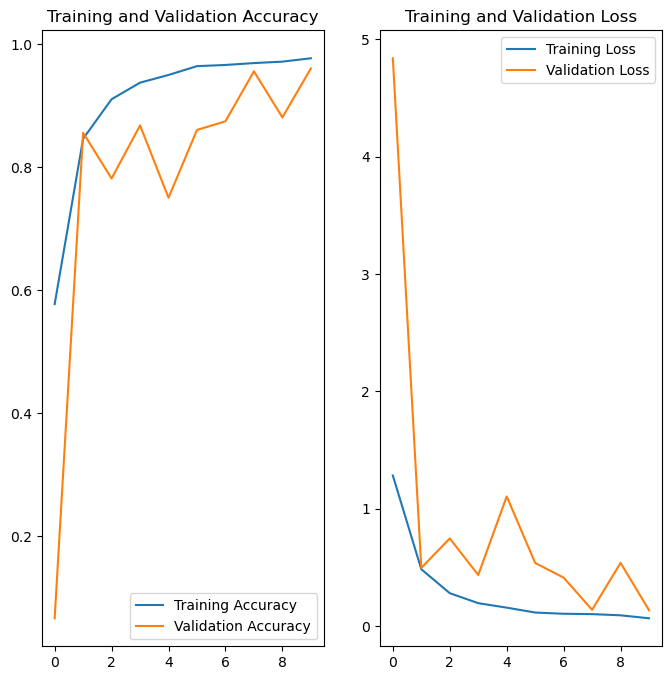

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.save('mobilenet_model.h5')

In [20]:
import tensorflow
saved_model = tensorflow.keras.models.load_model("mobilenet_model.h5")

In [21]:
saved_model.evaluate(X_test,y_test_encode)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9678 - loss: 0.1036


[0.13648918271064758, 0.9603333473205566]

In [22]:
out = saved_model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [23]:
output = np.zeros((y_test_encode.shape))
for i in range(out.shape[0]):
    output[i] = np.argmax(out[i])

In [24]:
X_test.shape, y_test_encode.shape, output.shape

((3000, 224, 224, 3), (3000, 1), (3000, 1))

In [25]:
output

array([[ 5.],
       [ 5.],
       [ 5.],
       ...,
       [13.],
       [13.],
       [13.]])

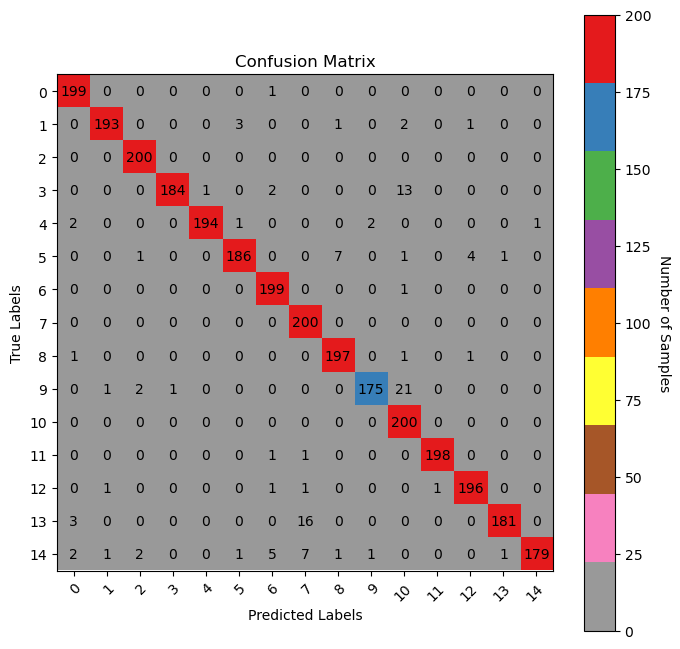

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ground truth labels
y_true = y_test_encode

# predicted labels
y_pred = output
# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# define labels for plotting
labels = [str(i) for i in range(15)]

# plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Set1_r')

# show all ticks and label them with corresponding list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

# set plot title and axis labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Number of Samples", rotation=-90, va="bottom")

# show the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Tomato


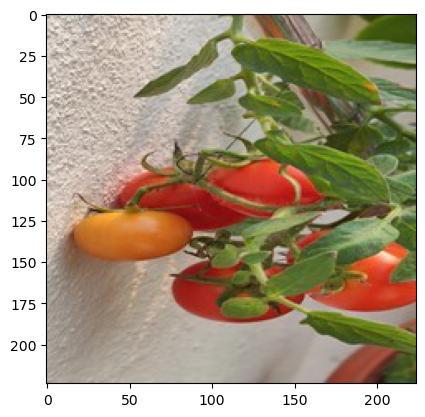

In [27]:
index = np.random.randint(X_test.shape[0])

# img = cv.imread(X_test[index])
# img_cvt = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# img_resize = cv.resize(img_cvt,(224,224))

list_img = []
list_img.append(X_test[index])
list_img = np.array(list_img)
pred = saved_model.predict(list_img)
pred_labels = np.argmax(pred, axis=1)
print(label_name.get(pred_labels[0]))

plt.imshow(X_test[index])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[-10.644729    -9.272818     1.201323     5.4387145   -4.539644
   -2.5041173   -1.4384675  -12.374845    -0.44691414  -0.98398817
   16.708496   -11.695115    -5.7547727   -8.344736    -5.2886176 ]]
Papaya


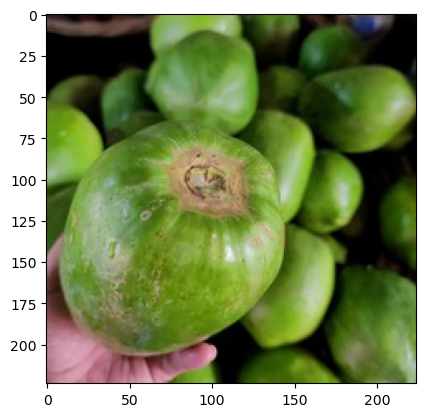

In [30]:
import cv2 as cv
img = cv.imread("Vegetable Images/test/Papaya/1198.jpg")
img_cvt = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resize = cv.resize(img_cvt,(224,224))

list_img = []
list_img.append(img_resize)
list_img = np.array(list_img)
pred = saved_model.predict(list_img)
print(pred)

pred_labels = np.argmax(pred, axis=1)
print(label_name.get(pred_labels[0]))

plt.imshow(img_resize)
plt.show()

In [31]:
img = cv.imread("Vegetable Images/test/Papaya/1198.jpg")